### Data Preparation

In [74]:
import os
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns



# reading data from csv
df = pd.read_csv(os.path.join('..', 'data_collection', 'final_result.csv'))
df


,categories.id,categories.name,categories.playlists.id,categories.playlists.name,categories.playlists.tracks.id,categories.playlists.tracks.name,categories.playlists.tracks.album.id,categories.playlists.tracks.album.name,categories.playlists.tracks.artists,categories.playlists.tracks.features.danceability,...,categories.playlists.tracks.features.loudness,categories.playlists.tracks.features.mode,categories.playlists.tracks.features.speechiness,categories.playlists.tracks.features.acousticness,categories.playlists.tracks.features.instrumentalness,categories.playlists.tracks.features.liveness,categories.playlists.tracks.features.valence,categories.playlists.tracks.features.tempo,categories.playlists.tracks.features.duration_ms,categories.playlists.tracks.features.time_signature
0,hiphop,Hip-Hop,37i9dQZF1DX0XUsuxWHRQd,RapCaviar,2AaJeBEq3WLcfFW1y8svDf,By Your Side,2RrZgDND03MLu6pRJdTkz5,By Your Side,Rod Wave,0.649,...,-10.232,1,0.0959,0.03450,0.000036,0.0736,0.405,157.975,194051,4
1,hiphop,Hip-Hop,37i9dQZF1DX0XUsuxWHRQd,RapCaviar,7uLFOXgLrS90tEYPO1DGXy,Man in the Mirror,1VxVQAgekwkFo8yoXvFZ8o,B4 AVA,A Boogie Wit da Hoodie,0.849,...,-4.241,0,0.0637,0.17100,0.000000,0.1490,0.550,135.997,215304,4
2,hiphop,Hip-Hop,37i9dQZF1DX0XUsuxWHRQd,RapCaviar,2lUDBd7JrgAMltcp6dcd7D,25 million,1eVrpJbHRLBbioB9sb5b94,LIVE LIFE FAST,Roddy Ricch,0.793,...,-9.258,1,0.1240,0.01900,0.000001,0.1390,0.395,132.202,204626,4
3,hiphop,Hip-Hop,37i9dQZF1DX0XUsuxWHRQd,RapCaviar,0qHPxjC83zQYcxe39xSShx,thailand,1eVrpJbHRLBbioB9sb5b94,LIVE LIFE FAST,Roddy Ricch,0.875,...,-10.562,1,0.2180,0.00717,0.000000,0.1470,0.409,128.990,200959,4
4,hiphop,Hip-Hop,37i9dQZF1DX0XUsuxWHRQd,RapCaviar,2QIBJFl8DJR1mDh9GwfZef,Don’t Play (with Lil Baby),2rLqUcipEjIKK9rma5OTN8,Hall of Fame 2.0,"Polo G,Lil Baby",0.684,...,-7.414,0,0.3470,0.23900,0.000000,0.1120,0.708,146.925,156735,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158317,funk,Funk & Disco,37i9dQZF1DX0oFpWfPwcGv,Disco Decadence,00Zum0eGUHgcE5l8MoNuUG,"Turn the Beat Around - 7"" Single Edit",7vlYGZ9hnsuC57PUiqy0WC,Never Gonna Let You Go (Expanded Edition),Vicki Sue Robinson,0.707,...,-7.540,0,0.0720,0.44500,0.000000,0.3660,0.822,131.242,204653,4
158318,funk,Funk & Disco,37i9dQZF1DX0oFpWfPwcGv,Disco Decadence,2vLaES21zwbX1Rnmj56Bbb,I'll Be Around,6QVemXFGMR4OLvlXvtQVjg,Spinners,The Spinners,0.593,...,-8.698,0,0.0680,0.17500,0.000000,0.0976,0.630,112.295,188800,4
158319,funk,Funk & Disco,37i9dQZF1DX0oFpWfPwcGv,Disco Decadence,3eudp9ZxZAGaDBOuWGrW2D,Got to Be Real - Single Version,059jmsqbxhu2n78LMS0H3P,Cheryl Lynn (Expanded Edition),Cheryl Lynn,0.830,...,-7.462,1,0.0448,0.20200,0.044800,0.1370,0.901,114.646,223173,4
158320,funk,Funk & Disco,37i9dQZF1DX0oFpWfPwcGv,Disco Decadence,3YJx77Xx8JSwEoxqrkQO5c,Knock on Wood,07ojYfe9B08p7nmOL2kgNF,Knock On Wood,Eddie Floyd,0.864,...,-12.918,1,0.0365,0.27700,0.005210,0.0514,0.964,105.164,189840,4


In [75]:
# drop duplicates by artist and track names
# this ensures that tracks that were released twice (e.g. single before album) are still deduplicated
# using the track id as a deduplication criteria wouldn't achieve this
df = df.drop_duplicates(subset=['categories.playlists.tracks.artists', 'categories.playlists.tracks.name'])

In [76]:
# list names of all genres
genres = df['categories.name'].unique()
genres

array(['Hip-Hop', 'Pop', 'Country', 'Rock', 'Latin', 'R&B', 'Mood',
       'Indie', 'Regional Mexican', 'Dance/Electronic',
       'Christian & Gospel', 'Chill', 'Party', 'Folk & Acoustic', 'K-Pop',
       'Instrumental', 'Ambient', 'Alternative', 'Classical', 'Jazz',
       'Soul', 'Punk', 'Blues', 'Arab', 'Metal', 'Caribbean',
       'Funk & Disco'], dtype=object)

In [77]:
# only use these genres

genre_filter = ['hiphop', 'jazz', 'rock']
df = df[df['categories.id'].isin(genre_filter)]

In [78]:
# Drop unneeded columns

columns_to_drop = [
    "categories.name",
    "categories.playlists.id",
    "categories.playlists.name",
    "categories.playlists.tracks.id",
    "categories.playlists.tracks.name",
    "categories.playlists.tracks.album.id",
    "categories.playlists.tracks.album.name",
    "categories.playlists.tracks.artists"
    ]
df = df.drop(columns=columns_to_drop)

df = df.rename(columns={
    "categories.id": "category",
    "categories.playlists.tracks.features.danceability": "feature_danceability",
    "categories.playlists.tracks.features.energy": "feature_energy",
    "categories.playlists.tracks.features.key": "feature_key",
    "categories.playlists.tracks.features.loudness": "feature_loudness",
    "categories.playlists.tracks.features.mode": "feature_mode",
    "categories.playlists.tracks.features.speechiness": "feature_speechiness",
    "categories.playlists.tracks.features.acousticness": "feature_acousticness",
    "categories.playlists.tracks.features.instrumentalness": "feature_instrumentalness",
    "categories.playlists.tracks.features.liveness": "feature_liveness",
    "categories.playlists.tracks.features.valence": "feature_valence",
    "categories.playlists.tracks.features.tempo": "feature_tempo",
    "categories.playlists.tracks.features.duration_ms": "feature_duration_ms",
    "categories.playlists.tracks.features.time_signature": "feature_time_signature"
})
df

,category,feature_danceability,feature_energy,feature_key,feature_loudness,feature_mode,feature_speechiness,feature_acousticness,feature_instrumentalness,feature_liveness,feature_valence,feature_tempo,feature_duration_ms,feature_time_signature
0,hiphop,0.649,0.5080,8,-10.232,1,0.0959,0.03450,0.000036,0.0736,0.4050,157.975,194051,4
1,hiphop,0.849,0.6310,3,-4.241,0,0.0637,0.17100,0.000000,0.1490,0.5500,135.997,215304,4
2,hiphop,0.793,0.4810,9,-9.258,1,0.1240,0.01900,0.000001,0.1390,0.3950,132.202,204626,4
3,hiphop,0.875,0.4780,7,-10.562,1,0.2180,0.00717,0.000000,0.1470,0.4090,128.990,200959,4
4,hiphop,0.684,0.6240,2,-7.414,0,0.3470,0.23900,0.000000,0.1120,0.7080,146.925,156735,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140510,jazz,0.421,0.0952,6,-12.561,1,0.0479,0.93100,0.000201,0.1260,0.0773,109.698,177922,4
140511,jazz,0.503,0.4910,0,-12.020,1,0.0295,0.04120,0.922000,0.0965,0.4890,166.105,263447,4
140512,jazz,0.644,0.5940,5,-9.965,1,0.1170,0.75100,0.224000,0.1070,0.6320,90.564,494467,4
140513,jazz,0.462,0.2110,0,-13.396,1,0.0586,0.66500,0.946000,0.1140,0.4260,179.658,77190,3


In [79]:
# sklearn takes the features and labels as seperate lists
# df needs to be split
def encode_target(df, target_column):

    df_mod = df.copy()
    map_to_int = {name: n for n, name in enumerate(df_mod["category"].unique())}
    df_mod["target"] = df_mod[target_column].replace(map_to_int)

    return (df_mod)

df_target = encode_target(df, "category")

# Target to category mapping
df_target[["target", "category"]].head()

,target,category
0,0,hiphop
1,0,hiphop
2,0,hiphop
3,0,hiphop
4,0,hiphop


In [80]:
# Possible values for category
targets = df_target["category"].unique()
targets

array(['hiphop', 'rock', 'jazz'], dtype=object)

### Train model

In [81]:
# Split test and training data
df_target_shuffled = df_target.sample(frac=1, random_state=45)
train, test = train_test_split(df_target_shuffled, test_size=0.2, random_state=45, shuffle=False)
print("Number of rows in train: ", train.shape[0])
print("Number of rows in test: ", test.shape[0])

Number of rows in train:  10701
Number of rows in test:  2676


In [82]:
# List of feature names

features = list(train.columns[1:14])
features

['feature_danceability',
 'feature_energy',
 'feature_key',
 'feature_loudness',
 'feature_mode',
 'feature_speechiness',
 'feature_acousticness',
 'feature_instrumentalness',
 'feature_liveness',
 'feature_valence',
 'feature_tempo',
 'feature_duration_ms',
 'feature_time_signature']

In [83]:
# y contains list of target values
y_train = train["target"]
y_test = test["target"]
y_all = df_target_shuffled["target"]

# X contains dataframe with feature columns
X_train = train[features]
X_test = test[features]
X_all = df_target_shuffled[features]

### Tuning hyperparameters

In [84]:
# New gbc for hyperparameter tuning
gbc_hp = GradientBoostingClassifier(random_state=45)

# Parameter grid. All possible combinations of these parameters are tried using GridSearchCV
param_grid = {
    "loss": ["deviance"],
    "n_estimators": [100],
    "learning_rate": [0.1],
    "criterion": ['friedman_mse'],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth": [3],
    "random_state": [42],
    "max_features": [None]

}

# Grid search object
search = GridSearchCV(gbc_hp, param_grid, n_jobs=-1, cv=5)

# Fitting model
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=45),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'], 'learning_rate': [0.1],
                         'loss': ['deviance'], 'max_depth': [3],
                         'max_features': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100],
                         'random_state': [42]})

In [85]:
# Score of the optimized boosting algorithm
y_score = search.score(X_test, y_test)

In [86]:
print(classification_report(y_test,search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       539
           1       0.87      0.91      0.89      1423
           2       0.84      0.77      0.80       714

    accuracy                           0.86      2676
   macro avg       0.85      0.84      0.85      2676
weighted avg       0.86      0.86      0.86      2676



In [87]:
d = {'Classes':    ['hiphop', 'rock', 'jazz'], 
     'Precision':  ['0.85', '0.87', '0.84'],
     'Recall':     ['0.85', '0.91', '0.77'],
     'F1-Score':   ['0.85', '0.89', '0.80'],
     'Support':    ['539', '1423', '714']
     }
df = pd.DataFrame(data=d)

df

,Classes,Precision,Recall,F1-Score,Support
0,hiphop,0.85,0.85,0.85,539
1,rock,0.87,0.91,0.89,1423
2,jazz,0.84,0.77,0.80,714


In [88]:
# https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python

df_confusion = pd.crosstab(y_test, search.predict(X_test), rownames=['Actual'], colnames=['Predicted'], margins=True)

df_confusion

Predicted,0,1,2,All
Actual,,,,
0,457,63,19,539
1,45,1294,84,1423
2,33,133,548,714
All,535,1490,651,2676


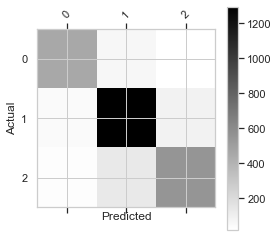

In [89]:
# https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

df_confusion = pd.crosstab(y_test, search.predict(X_test), rownames=['Actual'], colnames=['Predicted'])

plot_confusion_matrix(df_confusion)

ROC from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [90]:
# pre-steps for ROC

y = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y.shape[1]

n_classes

# create x_score 
y_test_new = []

for i in y_test:
    if i == 0:
        y_test_new.append([1, 0, 0])
    elif i == 1: 
        y_test_new.append([0, 1, 0])
    elif i == 2: 
        y_test_new.append([0, 0, 1])

# test input
y_test_np = np.asarray(y_test_new)

# score input
y_score = search.decision_function(X_test)

search.decision_function(X_test)

array([[-3.91292443,  0.9807969 , -3.19295542],
       [-3.55010532, -1.77072174,  2.1432507 ],
       [-3.00354229, -0.44253169, -1.35997936],
       ...,
       [-3.22499738, -0.30770263, -2.92978628],
       [-3.91613827, -0.55292234, -2.24169107],
       [-3.39415754,  1.37562042, -3.53073567]])

<Figure size 432x288 with 0 Axes>

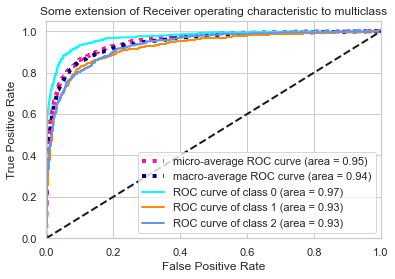

In [91]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_np[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_np.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


In [92]:
# feature importance 
# from https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
 
f = {'features' : features}

feature_importance = pd.DataFrame(f)

feature_importance['importance'] = search.best_estimator_.feature_importances_

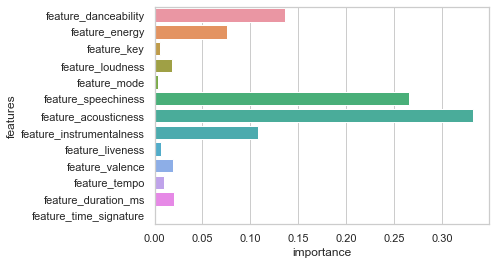

In [93]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(x="importance", y="features", data=feature_importance)